In [72]:
import pandas as pd

In [73]:
#pip install ipython-sql

 ### load data from database into a dataframe

In [74]:
%load_ext sql
%sql sqlite:///car_prediction_dataset.sqlite3

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Understanding the database structure
##### 1.There are two tables which contains data which we need.
##### 2.index column in model_info is actually model_id from model_with_companies .
##### 3.i.e model_id in model_with_companies is foreign key of model_info.
##### 4.We will perform inner join on index in model_info and model_id in model_with_companies and select only   rows required for our modelling.

In [75]:
%%sql 
results << SELECT 
       year,
       price,
       km_traveled,
       tax,
       enginesize,
       km_per_liters,
       mi.model,
       transmission,
       fuel_type
FROM   models_with_companies mc
       INNER JOIN model_info mi
               ON mc.model_id = mi."index"
WHERE  make = 'Chevrolet';

 * sqlite:///car_prediction_dataset.sqlite3
Done.
Returning data to local variable results


In [76]:
# converting the results into a dataframe and dropping unimportant columns 
df = results.DataFrame()

In [77]:
#pip install SQLAlchemy

In [78]:
from sqlalchemy import create_engine 
engine = create_engine("sqlite:///car_prediction_dataset.sqlite3")

query = """
SELECT
       year,
       price,
       km_traveled,
       tax,
       enginesize,
       km_per_liters,
       mi.model,
       transmission,
       fuel_type
FROM   models_with_companies mc
       INNER JOIN model_info mi
               ON mc.model_id = mi."index"
WHERE  make = 'Chevrolet'; 
"""

In [79]:
engine

Engine(sqlite:///car_prediction_dataset.sqlite3)

In [80]:
#df = pd.read_sql_query(query, con = engine)

In [81]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

In [82]:
df.to_csv('car_price_data.csv')

#### Check for null values

In [83]:
df.isnull().sum()

year             0
price            0
km_traveled      0
tax              0
engineSize       0
km_per_liters    0
model            0
transmission     0
fuel_type        0
dtype: int64

In [84]:
df.head()

,year,price,km_traveled,tax,engineSize,km_per_liters,model,transmission,fuel_type
0,2018,9491,39842.43038,0,1.5,20.364398,Camaro,Manual,Petrol
1,2002,3750,18158.18322,145,3.0,30.015166,TrailBlazer,Other,Petrol
2,2002,27000,24391.15704,0,1.5,25.040982,Silverado 2500 Extended Cab,Manual,Diesel
3,2005,19200,14405.20234,0,1.8,24.530809,Astro Cargo,Semi-Auto,Hybrid
4,2002,11995,34639.43416,145,1.0,24.658352,S10 Extended Cab,Automatic,Diesel


In [85]:
df.shape

(5101, 9)

In [86]:
df.size

45909

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5101 entries, 0 to 5100
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           5101 non-null   object 
 1   price          5101 non-null   int64  
 2   km_traveled    5101 non-null   float64
 3   tax            5101 non-null   int64  
 4   engineSize     5101 non-null   float64
 5   km_per_liters  5101 non-null   float64
 6   model          5101 non-null   object 
 7   transmission   5101 non-null   object 
 8   fuel_type      5101 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 358.8+ KB


In [88]:
### our dataset doesnot contains any null values

In [89]:
#converting categorical values into numerical values

In [90]:
df1=df.drop(['price'],axis=1)

In [91]:
df1.head()

,year,km_traveled,tax,engineSize,km_per_liters,model,transmission,fuel_type
0,2018,39842.43038,0,1.5,20.364398,Camaro,Manual,Petrol
1,2002,18158.18322,145,3.0,30.015166,TrailBlazer,Other,Petrol
2,2002,24391.15704,0,1.5,25.040982,Silverado 2500 Extended Cab,Manual,Diesel
3,2005,14405.20234,0,1.8,24.530809,Astro Cargo,Semi-Auto,Hybrid
4,2002,34639.43416,145,1.0,24.658352,S10 Extended Cab,Automatic,Diesel


In [92]:
df1['fuel_type'].value_counts()

Hybrid    1574
Other     1378
Diesel    1085
Petrol    1064
Name: fuel_type, dtype: int64

In [93]:
df['model'].nunique()

120

In [94]:
df.corr()


,price,km_traveled,tax,engineSize,km_per_liters
price,1.000000,-0.002491,-0.007105,-0.009075,-0.017848
km_traveled,-0.002491,1.000000,0.007029,0.006570,-0.015372
tax,-0.007105,0.007029,1.000000,-0.007840,0.020564
engineSize,-0.009075,0.006570,-0.007840,1.000000,-0.005883
km_per_liters,-0.017848,-0.015372,0.020564,-0.005883,1.000000


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

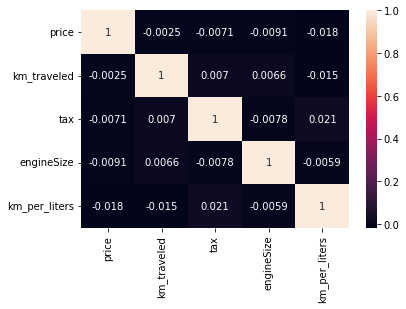

In [96]:
sns.heatmap(df.corr(),annot=True)

In [97]:
#### applying hypothesis testing 

In [98]:
# h0= there is no relation between two variables
#ha=  there is relation between two variables

In [99]:
from scipy.stats import chi2_contingency

In [100]:
for cols in df1.columns:
    if df[cols].dtype=='object':
        from scipy.stats import chi2_contingency
        chi_df=pd.crosstab(df1[cols],df['price'])
        a,p_value,b,c=chi2_contingency(chi_df)
        print(f'{cols} has p_value of {p_value}')

year has p_value of 0.7272439282964366
model has p_value of 9.699762959136516e-18
transmission has p_value of 0.5737596449565006
fuel_type has p_value of 0.19903049412930943


In [101]:
df1=df.drop(['model'],axis=1)

In [102]:
df['tax'].value_counts()

145    1546
0      1371
135     538
30      432
150     417
20      185
140     169
125     152
260      80
200      58
205      32
265      24
160      24
10       17
235      15
165      11
325      11
300       9
240       5
330       4
305       1
Name: tax, dtype: int64

In [103]:
### from chi-squre test we can say that fuel_type 
# 1) as p_value is less than 0.5 , model has very week or no relation with model column
# 2) fuel type is seems to be highly correlatd to price 

<AxesSubplot:xlabel='km_traveled', ylabel='Count'>

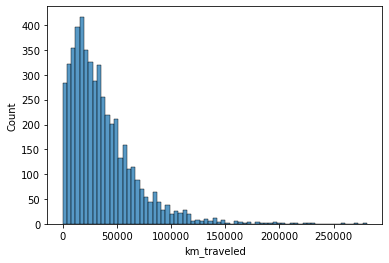

In [104]:
sns.histplot(df1['km_traveled'])

<AxesSubplot:xlabel='km_per_liters', ylabel='Count'>

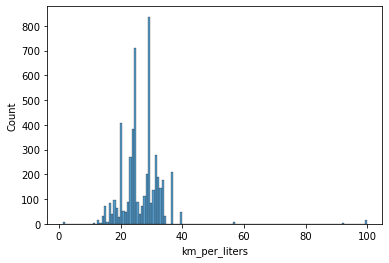

In [105]:
sns.histplot(df['km_per_liters'])

In [106]:
df1.describe()

,price,km_traveled,tax,engineSize,km_per_liters
count,5101.000000,5101.000000,5101.000000,5101.000000,5101.000000
mean,12544.586944,36194.765202,94.577534,1.462615,26.885070
std,6502.942608,30260.285298,73.438069,0.434412,6.916482
min,950.000000,4.828020,0.000000,0.000000,1.190403
25%,8190.000000,15042.500980,0.000000,1.000000,23.552978
50%,10610.000000,29186.990240,135.000000,1.500000,26.699043
75%,14995.000000,49123.494160,145.000000,1.800000,30.015166
max,59995.000000,280699.473460,330.000000,3.000000,99.908840


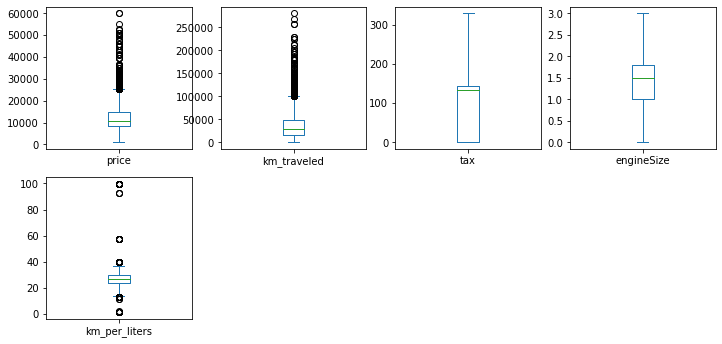

In [107]:
df1.plot(kind='box',figsize=(12,12), layout=(4,4),subplots=True);

In [108]:
col=['km_traveled','km_per_liters']

In [109]:
def remove_outlies(df,n):
    more_than=0
    lower_than=0
    sum=0
    for j in col:
        if df[j].dtype in ('int64','float64'):
            a=np.mean(df[j])
            b=np.std(df[j])
            c=a+(n*b)
            d=a-(n*b)
            for i in range(0,len(df)):
                if df[j].iloc[i]>c:
                    df[j].iloc[i]=c
                    more_than=more_than+1
                if df[j].iloc[i]<d:
                    df[j].iloc[i]=d
                    lower_than=lower_than+1
                else:
                    pass
                total=more_than+ lower_than
            print(f'{j} has lower_outliers{lower_than} and higher-outlier {more_than} and total outliers {total}')

In [110]:
remove_outlies(df1,3)

C:\Users\Shree\AppData\Local\Temp\ipykernel_7864\904196194.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[j].iloc[i]=c


km_traveled has lower_outliers0 and higher-outlier 78 and total outliers 78


C:\Users\Shree\AppData\Local\Temp\ipykernel_7864\904196194.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[j].iloc[i]=d


km_per_liters has lower_outliers10 and higher-outlier 103 and total outliers 113


In [111]:
### iin case of tax will have to remove values from upper limit i.e- a+(n*b)

In [112]:
col1=['tax']

In [113]:
def remove_outlies(df,n):
    more_than=0
    sum=0
    for j in col1:
        if df[j].dtype in ('int64','float64'):
            a=np.mean(df[j])
            b=np.std(df[j])
            c=a+(n*b)
            for i in range(0,len(df)):
                if df[j].iloc[i]>c:
                    df[j].iloc[i]=c
                    more_than=more_than+1
                else:
                    pass
                total=more_than
            print(f' higher-outlier {more_than} and total outliers {total}')

In [114]:
remove_outlies(df1,3)

C:\Users\Shree\AppData\Local\Temp\ipykernel_7864\2637598660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[j].iloc[i]=c


 higher-outlier 15 and total outliers 15


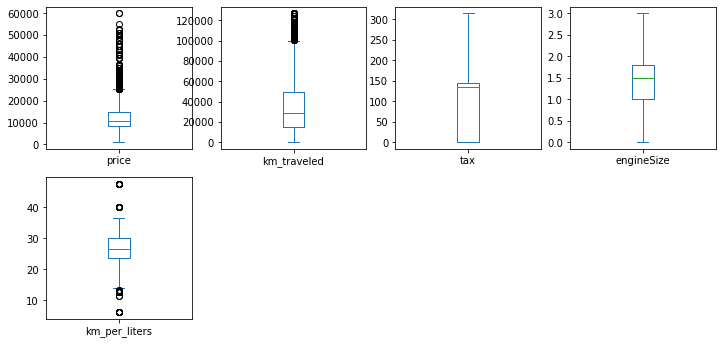

In [115]:
df1.plot(kind='box',figsize=(12,12), layout=(4,4),subplots=True);

In [116]:
### converting categorical columns into numerical

<AxesSubplot:xlabel='km_traveled', ylabel='Count'>

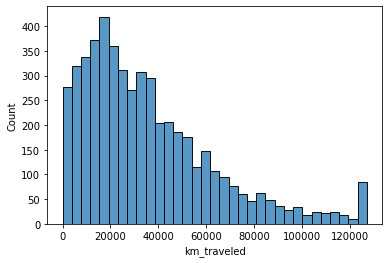

In [117]:
sns.histplot(df1['km_traveled'])

In [118]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder

In [119]:
le=LabelEncoder()
ohe=OneHotEncoder(handle_unknown='ignore', sparse=False)
ord_encoder = OrdinalEncoder()


In [120]:
df1['year']=np.array(df1['year'])

In [121]:
df1['year']

0       2018
1       2002
2       2002
3       2005
4       2002
        ... 
5096    2011
5097    2018
5098    1995
5099    1995
5100    1999
Name: year, Length: 5101, dtype: object

In [122]:
df1['year']=le.fit_transform(df1['year'])

In [123]:
df1=pd.get_dummies(df1)

In [124]:
df1.head()

,year,price,km_traveled,tax,engineSize,km_per_liters,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuel_type_Diesel,fuel_type_Hybrid,fuel_type_Other,fuel_type_Petrol
0,26,9491,39842.43038,0.0,1.5,20.364398,0,1,0,0,0,0,0,1
1,10,3750,18158.18322,145.0,3.0,30.015166,0,0,1,0,0,0,0,1
2,10,27000,24391.15704,0.0,1.5,25.040982,0,1,0,0,1,0,0,0
3,13,19200,14405.20234,0.0,1.8,24.530809,0,0,0,1,0,1,0,0
4,10,11995,34639.43416,145.0,1.0,24.658352,1,0,0,0,1,0,0,0


In [125]:
from sklearn.preprocessing import StandardScaler

In [126]:
std=StandardScaler()

In [127]:
std_df=std.fit_transform(df1)

In [128]:
a=list(df1.columns)

In [129]:
final_df=pd.DataFrame(std_df)

In [130]:
final_df.columns=a

In [131]:
final_df.head()

,year,price,km_traveled,tax,engineSize,km_per_liters,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuel_type_Diesel,fuel_type_Hybrid,fuel_type_Other,fuel_type_Petrol
0,1.547188,-0.469616,0.152295,-1.289346,0.086067,-1.142011,-0.519170,1.547947,-0.578482,-0.565804,-0.519778,-0.668036,-0.608384,1.947864
1,-0.447998,-1.352534,-0.629644,0.688099,3.539348,0.594901,-0.519170,-0.646017,1.728662,-0.565804,-0.519778,-0.668036,-0.608384,1.947864
2,-0.447998,2.223121,-0.404882,-1.289346,0.086067,-0.300336,-0.519170,1.547947,-0.578482,-0.565804,1.923898,-0.668036,-0.608384,-0.513383
3,-0.073900,1.023547,-0.764978,-1.289346,0.776723,-0.392155,-0.519170,-0.646017,-0.578482,1.767395,-0.519778,1.496926,-0.608384,-0.513383
4,-0.447998,-0.084522,-0.035326,0.688099,-1.065027,-0.369200,1.926153,-0.646017,-0.578482,-0.565804,1.923898,-0.668036,-0.608384,-0.513383


In [132]:
final_df1=pd.concat([final_df,df['price']],axis=1)

In [133]:
final_df1.head()

,year,price,km_traveled,tax,engineSize,km_per_liters,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuel_type_Diesel,fuel_type_Hybrid,fuel_type_Other,fuel_type_Petrol,price
0,1.547188,-0.469616,0.152295,-1.289346,0.086067,-1.142011,-0.519170,1.547947,-0.578482,-0.565804,-0.519778,-0.668036,-0.608384,1.947864,9491
1,-0.447998,-1.352534,-0.629644,0.688099,3.539348,0.594901,-0.519170,-0.646017,1.728662,-0.565804,-0.519778,-0.668036,-0.608384,1.947864,3750
2,-0.447998,2.223121,-0.404882,-1.289346,0.086067,-0.300336,-0.519170,1.547947,-0.578482,-0.565804,1.923898,-0.668036,-0.608384,-0.513383,27000
3,-0.073900,1.023547,-0.764978,-1.289346,0.776723,-0.392155,-0.519170,-0.646017,-0.578482,1.767395,-0.519778,1.496926,-0.608384,-0.513383,19200
4,-0.447998,-0.084522,-0.035326,0.688099,-1.065027,-0.369200,1.926153,-0.646017,-0.578482,-0.565804,1.923898,-0.668036,-0.608384,-0.513383,11995


In [134]:
from sklearn.model_selection import train_test_split

In [135]:
train_df,test_df=train_test_split(final_df1,train_size=0.8,random_state=43)

In [136]:
x_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,[-1]]
x_test=test_df.iloc[:,:-1]
y_test=test_df.iloc[:,[-1]]



In [137]:
y_test

,price
1365,14995
1185,10000
2011,10000
2783,6595
4831,10195
...,...
3532,14995
2675,25650
4078,7785
283,12100


In [138]:
from sklearn.linear_model import LinearRegression

In [139]:
lr=LinearRegression()

In [140]:
lr.fit(x_train,y_train)

LinearRegression()

In [141]:
pred_lr_train=lr.predict(x_train)

In [142]:
pred_lr_test=lr.predict(x_test)

In [143]:
from sklearn.metrics import r2_score

In [144]:
r2_score(y_train,pred_lr_train)

1.0

In [145]:
df5=pd.DataFrame()

In [146]:
df5['actual']=y_train

In [147]:
r2_score(y_test,pred_lr_test)

1.0

In [148]:
#### model seems to be getting over fitted

In [149]:
from sklearn.linear_model import Lasso

In [150]:
rg=Lasso()

In [151]:
rg.fit(x_train,y_train)

Lasso()

In [152]:
y_pred_lasso_train=rg.predict(x_train)

In [153]:
y_pred_lasso_test=rg.predict(x_test)

In [154]:
r2_score(y_train,y_pred_lasso_train)

0.9999999752200742

In [155]:
r2_score(y_test,y_pred_lasso_test)

0.9999999752094381

#### applying ridge regression

In [156]:
from sklearn.linear_model import Ridge

In [157]:
rige=Ridge()

In [158]:
rige.fit(x_train,y_train)

Ridge()

In [159]:
pred_rige_test=rige.predict(x_test)

In [160]:
r2_score(y_test,pred_rige_test)

0.9999999373454257

In [161]:
#### applying dicission tree regression

In [162]:
from sklearn.tree import DecisionTreeRegressor

In [163]:
dr=DecisionTreeRegressor()

In [164]:
dr.fit(x_train,y_train)

DecisionTreeRegressor()

In [165]:
pred_dr_test=dr.predict(x_test)

In [166]:
r2_score(y_test,pred_dr_test)

0.9977511399256915

In [167]:
####

In [168]:
#applying adboost regrerssor

In [169]:
from sklearn.ensemble import GradientBoostingRegressor

In [170]:
gdboost=GradientBoostingRegressor()

In [171]:
gdboost.fit(x_train,y_train)

C:\Users\Shree\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor()

In [172]:
pred_boost=gdboost.predict(x_test)

In [173]:
r2_score(y_test,pred_boost)

0.9976531073111726

In [174]:
#### gradient boost algorithem seems to be stable

In [175]:
import pickle

In [176]:
filename='car_price_prediction_pkl'

In [177]:
with open(filename,'wb') as f:
    pickle.dump(gdboost,f)

In [178]:
##### loading a model

In [181]:
with open(filename,'rb') as f:
    model=pickle.load(f)